# Leishmania Drug Discovery

<!-- ![Capture11111.PNG](attachment:Capture11111.PNG) -->

### Import libs

In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import Image
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
from rdkit.Chem import DataStructs
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import pandas as pd
import numpy as np
np.random.seed(1779177)
import os
#import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

### Load Data

In [2]:
drug_c = pd.read_csv("drugCentral.csv")
endogenous = pd.read_csv("endogenous.csv")
in_trails = pd.read_csv("in-trials.csv")
world = pd.read_csv("world.csv")
data = pd.read_csv("Bioactivities.csv",sep='\t')
data1 = pd.read_csv("Bioactivities1.csv", sep=';',low_memory=False)

In [3]:
# df1 = pd.read_csv('Bioactivities2.csv',sep='\t',low_memory=False)

## Data Cleaning 

### Remove duplicates

In [4]:
df1 = data1.dropna(subset=['Smiles', 'Molecule ChEMBL ID']).drop_duplicates(subset=['Molecule ChEMBL ID'])

### Select Type Inhibition only

In [5]:
df_activity1 = df1.loc[(df1['Standard Type'] == 'Inhibition') & (df1['Standard Units'] == '%')].dropna(subset=['Standard Value'])
df_activity1['logValue'] = 1 * np.log(df_activity1['Standard Value'])

/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Log transformation

In [6]:
df1['logValue'] = df_activity1['logValue']

### Remove Inf and -Inf from data

In [7]:
df1 = df1.replace([np.inf, -np.inf], np.nan).dropna(subset=['logValue'], how="all")


## Feature Engineering

### Get molecules objects from SMILES notaion 

In [8]:
df1['mol'] = df1['Smiles'].apply(Chem.MolFromSmiles)

### Add descriptive Features for all the molecules

In [9]:
df1 = df1.dropna(subset=['mol'])
df1['HeavyAtomCount'] = df1['mol'].apply(Descriptors.HeavyAtomCount)
df1['HAccept'] = df1['mol'].apply(Descriptors.NumHAcceptors)
df1['HDonor'] = df1['mol'].apply(Descriptors.NumHDonors)
df1['Heteroatoms'] = df1['mol'].apply(Descriptors.NumHeteroatoms)
df1['RingCount'] = df1['mol'].apply(Descriptors.RingCount)
df1['SaturatedRings'] = df1['mol'].apply(Descriptors.NumSaturatedRings)
df1['AliphaticRings'] = df1['mol'].apply(Descriptors.NumAliphaticRings)
df1['AromaticRings'] = df1['mol'].apply(Descriptors.NumAromaticRings)
df1['Ipc'] = df1['mol'].apply(Descriptors.Ipc)
df1['HallKierAlpha'] = df1['mol'].apply(Descriptors.HallKierAlpha)
df1['NumValenceElectrons'] = df1['mol'].apply(Descriptors.NumValenceElectrons)
df1['MolLogP'] = df1['mol'].apply(Descriptors.MolLogP)
df1['AMW'] = df1['mol'].apply(Descriptors.MolWt)
df1['NumRotatableBonds'] = df1['mol'].apply(Descriptors.NumRotatableBonds)

In [10]:
X1 = df1[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']]
y1 = df1['logValue']

## Prepare for Training

### Train/valid/test Split and scaling 

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
scaler_xtrain = RobustScaler()


X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.11, random_state=1995)
                                                    
# X_train, X_valid, y_train, y_valid = train_test_split(X1,y1, test_size=0.3, random_state=1995)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, test_size=0.2, random_state=1995)


X_train = scaler_xtrain.fit_transform(X_train) 
# y_train = scaler_xtrain.transform(y_train.to_numpy().reshape(-1,1))

X_valid = scaler_xtrain.transform(X_valid)
# y_valid = scaler_xtrain.transform(y_valid.to_numpy().reshape(-1,1))

X_test = scaler_xtrain.transform(X_test)
# y_test = scaler_xtrain.transform(y_test.to_numpy().reshape(-1,1))

## TabNet: Attentive Interpretable Tabular Learning

### Model

In [12]:
batch_size = 16384
max_epochs = 1000 
clf = TabNetRegressor(n_d = 32 , n_a = 32 , n_independent = 4, n_shared =4 , n_steps=4 ,lambda_sparse = 1e-3,
    optimizer_fn=torch.optim.Adam, # Any optimizer works here
                       optimizer_params=dict(lr=2e-2),
                       scheduler_fn=torch.optim.lr_scheduler.ExponentialLR,
                       scheduler_params={"gamma":0.98 # max because default eval metric for binary is AUC
#                                          "factor":0.001,
#                                          "patience":10,
                                        },
                       mask_type='entmax', # "sparsemax",entmax
                      )

Device used : cuda


### Training

In [13]:
clf.fit(
    X_train=X_train, y_train=y_train.to_numpy().reshape(-1,1),
    eval_set=[(X_train, y_train.to_numpy().reshape(-1,1)), (X_valid, y_valid.to_numpy().reshape(-1,1))],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=batch_size, virtual_batch_size=128,
    num_workers=5,
    drop_last=False
)

epoch 0  | loss: 5.74451 | train_mse: 38.25975| valid_mse: 23.19162|  0:00:03s
epoch 1  | loss: 1.68352 | train_mse: 3.58135 | valid_mse: 3.79856 |  0:00:07s
epoch 2  | loss: 1.2839  | train_mse: 1.10532 | valid_mse: 0.84834 |  0:00:11s
epoch 3  | loss: 0.83205 | train_mse: 0.92903 | valid_mse: 0.75198 |  0:00:14s
epoch 4  | loss: 0.97688 | train_mse: 0.72547 | valid_mse: 0.70449 |  0:00:18s
epoch 5  | loss: 0.82935 | train_mse: 0.62694 | valid_mse: 0.62339 |  0:00:21s
epoch 6  | loss: 0.66948 | train_mse: 0.60943 | valid_mse: 0.62355 |  0:00:25s
epoch 7  | loss: 0.58083 | train_mse: 0.51828 | valid_mse: 0.53597 |  0:00:29s
epoch 8  | loss: 0.53304 | train_mse: 0.49107 | valid_mse: 0.50156 |  0:00:32s
epoch 9  | loss: 0.50503 | train_mse: 0.48208 | valid_mse: 0.48703 |  0:00:36s
epoch 10 | loss: 0.48887 | train_mse: 0.48857 | valid_mse: 0.49629 |  0:00:40s
epoch 11 | loss: 0.48268 | train_mse: 0.48    | valid_mse: 0.49562 |  0:00:43s
epoch 12 | loss: 0.47765 | train_mse: 0.47406 | vali

epoch 104| loss: 0.45848 | train_mse: 0.45652 | valid_mse: 0.47305 |  0:06:20s
epoch 105| loss: 0.45923 | train_mse: 0.45657 | valid_mse: 0.47264 |  0:06:23s
epoch 106| loss: 0.45858 | train_mse: 0.45658 | valid_mse: 0.47319 |  0:06:27s
epoch 107| loss: 0.45903 | train_mse: 0.45624 | valid_mse: 0.47285 |  0:06:31s
epoch 108| loss: 0.45858 | train_mse: 0.45629 | valid_mse: 0.47288 |  0:06:34s
epoch 109| loss: 0.45862 | train_mse: 0.45638 | valid_mse: 0.47279 |  0:06:38s
epoch 110| loss: 0.45913 | train_mse: 0.45602 | valid_mse: 0.47237 |  0:06:41s
epoch 111| loss: 0.45881 | train_mse: 0.45652 | valid_mse: 0.47256 |  0:06:45s
epoch 112| loss: 0.45898 | train_mse: 0.45715 | valid_mse: 0.47242 |  0:06:49s
epoch 113| loss: 0.45839 | train_mse: 0.45673 | valid_mse: 0.47294 |  0:06:52s
epoch 114| loss: 0.45859 | train_mse: 0.45651 | valid_mse: 0.47253 |  0:06:56s
epoch 115| loss: 0.45786 | train_mse: 0.4566  | valid_mse: 0.47226 |  0:06:59s
epoch 116| loss: 0.45824 | train_mse: 0.45699 | vali

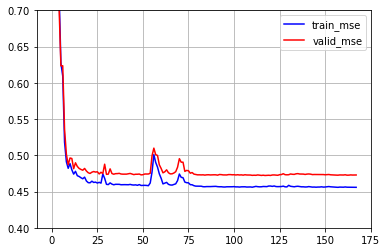

In [14]:
# plot losses
# plt.plot(clf.history['loss'])
plt.plot(clf.history['train_mse'],'b')
plt.plot(clf.history['valid_mse'],'r')
plt.legend(['train_mse','valid_mse'])
plt.grid(True)
plt.gca().set_ylim(0.4, 0.7) 
plt.show()

In [15]:
Checkingpreds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE  : {clf.best_cost}")
print(f"FINAL TEST SCORE  : {test_score}")

BEST VALID SCORE  : 0.4721820479649035
FINAL TEST SCORE  : 0.4648419391728419


### Prepare Drugs at trials

In [16]:
in_trails = in_trails.drop_duplicates()

In [17]:
in_trails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 0 to 9799
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zinc_id  9800 non-null   object
 1   smiles   9800 non-null   object
dtypes: object(2)
memory usage: 229.7+ KB


In [18]:
in_trails['mol'] = in_trails['smiles'].apply(Chem.MolFromSmiles)

In [19]:
in_trails = in_trails.dropna(subset=['mol'])
in_trails['HeavyAtomCount'] = in_trails['mol'].apply(Descriptors.HeavyAtomCount)
in_trails['HAccept'] = in_trails['mol'].apply(Descriptors.NumHAcceptors)
in_trails['HDonor'] = in_trails['mol'].apply(Descriptors.NumHDonors)
in_trails['Heteroatoms'] = in_trails['mol'].apply(Descriptors.NumHeteroatoms)
in_trails['RingCount'] = in_trails['mol'].apply(Descriptors.RingCount)
in_trails['SaturatedRings'] = in_trails['mol'].apply(Descriptors.NumSaturatedRings)
in_trails['AliphaticRings'] = in_trails['mol'].apply(Descriptors.NumAliphaticRings)
in_trails['AromaticRings'] = in_trails['mol'].apply(Descriptors.NumAromaticRings)
in_trails['Ipc'] = in_trails['mol'].apply(Descriptors.Ipc)
in_trails['HallKierAlpha'] = in_trails['mol'].apply(Descriptors.HallKierAlpha)
in_trails['NumValenceElectrons'] = in_trails['mol'].apply(Descriptors.NumValenceElectrons)
in_trails['MolLogP'] = in_trails['mol'].apply(Descriptors.MolLogP)
in_trails['AMW'] = in_trails['mol'].apply(Descriptors.MolWt)
in_trails['NumRotatableBonds'] = in_trails['mol'].apply(Descriptors.NumRotatableBonds)

In [20]:
X_in_trails = in_trails[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']]

In [21]:
X_in_trails[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']] = scaler_xtrain.transform(X_in_trails[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']])


/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Making predictions

In [22]:
X_in_trails['pred'] = clf.predict(X_in_trails.to_numpy())


X_in_trails['smiles'] = in_trails['smiles']
X_in_trails['zinc_id'] = in_trails['zinc_id']


/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [23]:
X_in_trails.sort_values("pred", ascending=False).head(20)

,MolLogP,AMW,NumRotatableBonds,HeavyAtomCount,HAccept,HDonor,Heteroatoms,RingCount,SaturatedRings,AliphaticRings,AromaticRings,Ipc,HallKierAlpha,NumValenceElectrons,pred,smiles,zinc_id
6876,12.650479,11.814498,9.000000,10.00,-0.5,-0.5,-1.5,-1.0,-1.0,0.0,-2.0,1.554755e+07,-2.548780,11.3,54.421494,COC1=C(OC)C(=O)C(C/C=C(\C)CC/C=C(\C)CC/C=C(\C)...,ZINC000085427689
7543,-7.263342,14.462337,5.666667,8.00,11.0,3.5,18.0,-0.5,1.0,1.0,-2.0,4.653066e+04,1.134146,10.2,14.740351,O=S(=O)(O)OC[C@H]1O[C@@H](O[C@]2(COS(=O)(=O)O)...,ZINC000196037215
6675,-7.263342,14.462337,5.666667,8.00,11.0,3.5,18.0,-0.5,1.0,1.0,-2.0,4.653066e+04,1.134146,10.2,14.740351,O=S(=O)(O)OC[C@H]1O[C@@H](O[C@@]2(COS(=O)(=O)O...,ZINC000196037206
8400,-13.182345,14.640834,4.000000,11.00,13.0,9.5,12.0,1.5,5.0,5.0,-2.0,3.222478e+08,1.036585,13.4,11.149251,OC[C@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@@H]...,ZINC000299818012
112,-6.007365,14.332942,4.666667,11.25,9.5,6.5,8.5,0.5,3.0,3.0,-2.0,2.931798e+08,-1.939024,13.0,9.677798,CC(/C=C/C=C(\C)C(=O)O[C@@H]1O[C@H](CO[C@@H]2O[...,ZINC000936070151
8444,-6.007365,14.332942,4.666667,11.25,9.5,6.5,8.5,0.5,3.0,3.0,-2.0,2.931798e+08,-1.939024,13.0,9.677798,CC(/C=C/C=C(\C)C(=O)O[C@@H]1O[C@H](CO[C@@H]2O[...,ZINC000245224178
649,-5.174520,14.068233,4.000000,11.50,4.5,6.5,8.5,1.0,1.0,1.0,1.0,7.380236e+08,-5.975610,12.5,9.270931,CC(=O)N[C@H]1[C@H](NC(=O)C[C@H](N)C(=O)N[C@H]2...,ZINC000255990532
5137,-5.104591,13.668876,2.333333,11.25,4.0,6.0,8.0,1.5,2.0,2.0,1.0,6.675579e+08,-5.926829,12.1,8.891053,CC(=O)N[C@H]1[C@H](NC(=O)C[C@@H]2NC(=O)[C@H](C...,ZINC000169676912
1501,-8.128524,11.692729,6.666667,9.25,5.5,7.5,9.0,-1.0,-1.0,-1.0,-1.0,1.794391e+06,-4.756098,10.6,8.775519,C[C@H](N)C(=O)N[C@@H](CO)C(=O)N[C@H](C(=O)N[C@...,ZINC000169345692
6763,-9.282639,9.892219,2.666667,7.50,8.0,6.5,9.0,0.5,3.0,3.0,-2.0,2.150610e+05,-0.865854,9.0,8.694906,CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](C(=O)O)O[C@@...,ZINC000096014305


In [44]:
X_in_trails['smiles'].iloc[112]

'CC(/C=C/C=C(\\C)C(=O)O[C@@H]1O[C@H](CO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H](O)[C@H]1O)=C\\C=C/C=C(C)/C=C/C=C(\\C)C(=O)O[C@@H]1O[C@H](CO[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@H](O)[C@H]1O'

In [24]:
best_predicted = X_in_trails[["smiles"]].values[:20,0]
best_predicted_mols = [Chem.MolFromSmiles(x) for x in best_predicted]

### Checking Top 20 compounds 

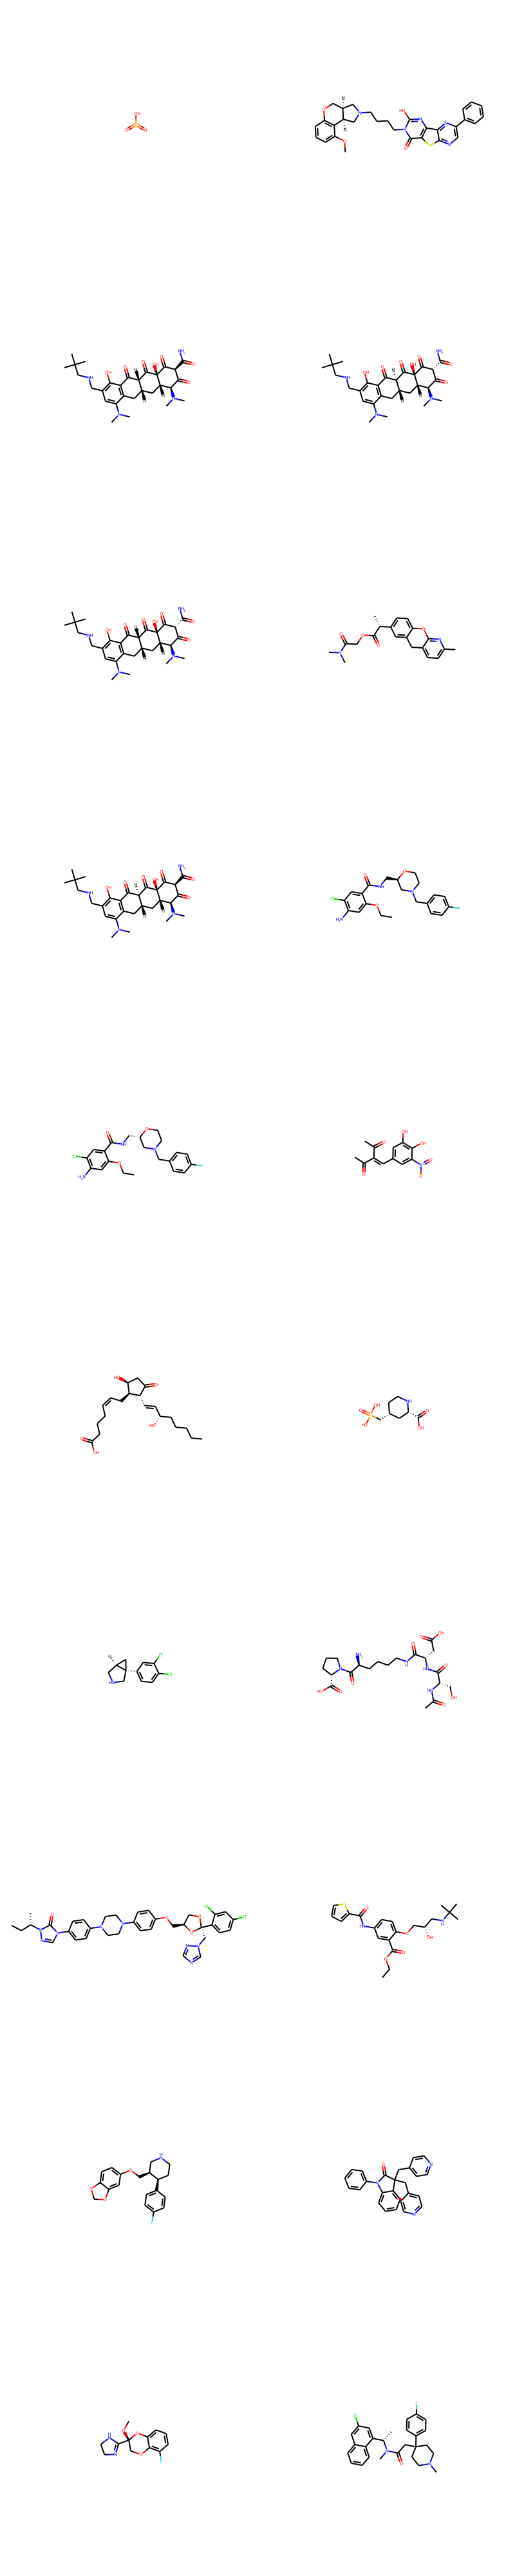

In [25]:
rdkit.Chem.Draw.MolsToGridImage(best_predicted_mols, molsPerRow=2, maxMols=100, subImgSize=(400, 400))

## AutoDock Vina Validation
### Binding Affinty of -4.74!! 

#### 4-(Benzylideneamino)benzenesulfonamide

<!-- ![1.png](attachment:1.png) -->

<!-- ![2.png](attachment:2.png) -->

<!-- ![3.png](attachment:3.png) -->

### Prepare Random Approved Selected Drugs

In [26]:
endogenous = endogenous.drop_duplicates()

In [27]:
endogenous.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81519 entries, 0 to 81518
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   zinc_id  81519 non-null  object
 1   smiles   81519 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [28]:
endogenous['mol'] = endogenous['smiles'].apply(Chem.MolFromSmiles)
endogenous = endogenous.dropna(subset=['mol'])
endogenous['HeavyAtomCount'] = endogenous['mol'].apply(Descriptors.HeavyAtomCount)
endogenous['HAccept'] = endogenous['mol'].apply(Descriptors.NumHAcceptors)
endogenous['HDonor'] = endogenous['mol'].apply(Descriptors.NumHDonors)
endogenous['Heteroatoms'] = endogenous['mol'].apply(Descriptors.NumHeteroatoms)
endogenous['RingCount'] = endogenous['mol'].apply(Descriptors.RingCount)
endogenous['SaturatedRings'] = endogenous['mol'].apply(Descriptors.NumSaturatedRings)
endogenous['AliphaticRings'] = endogenous['mol'].apply(Descriptors.NumAliphaticRings)
endogenous['AromaticRings'] = endogenous['mol'].apply(Descriptors.NumAromaticRings)
endogenous['Ipc'] = endogenous['mol'].apply(Descriptors.Ipc)
endogenous['HallKierAlpha'] = endogenous['mol'].apply(Descriptors.HallKierAlpha)
endogenous['NumValenceElectrons'] = endogenous['mol'].apply(Descriptors.NumValenceElectrons)
endogenous['MolLogP'] = endogenous['mol'].apply(Descriptors.MolLogP)
endogenous['AMW'] = endogenous['mol'].apply(Descriptors.MolWt)
endogenous['NumRotatableBonds'] = endogenous['mol'].apply(Descriptors.NumRotatableBonds)

RDKit WARNING: [08:26:11] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [08:26:11]   BondStereo set to STEREONONE and single bond directions set to NONE.
RDKit WARNING: [08:26:11] Conflicting single bond directions around double bond at index 1.
RDKit WARNING: [08:26:11]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [29]:
X_endogenous = endogenous[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']]ZINC000261496575

In [30]:
X_endogenous[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']] = scaler_xtrain.transform(X_endogenous[['MolLogP', 'AMW', 'NumRotatableBonds', 'HeavyAtomCount',
       'HAccept', 'HDonor', 'Heteroatoms', 'RingCount', 'SaturatedRings',
       'AliphaticRings', 'AromaticRings', 'Ipc', 'HallKierAlpha',
       'NumValenceElectrons']])

/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Making predictions

In [31]:
X_endogenous['pred'] = clf.predict(X_endogenousZINC000261496575.to_numpy())


X_endogenous['smiles'] = endogenous['smiles']
X_endogenous['zinc_id'] = endogenous['zinc_id']


/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/moazmohamed/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [1]:
X_endogenous.sort_values("pred", ascending=False).head(100)

NameError: name 'X_endogenous' is not defined

In [33]:
best_predicted = X_endogenous[["smiles"]].values[:20,0]
best_predicted_mols = [Chem.MolFromSmiles(x) for x in best_predicted]

### Checking Top 20 compounds 

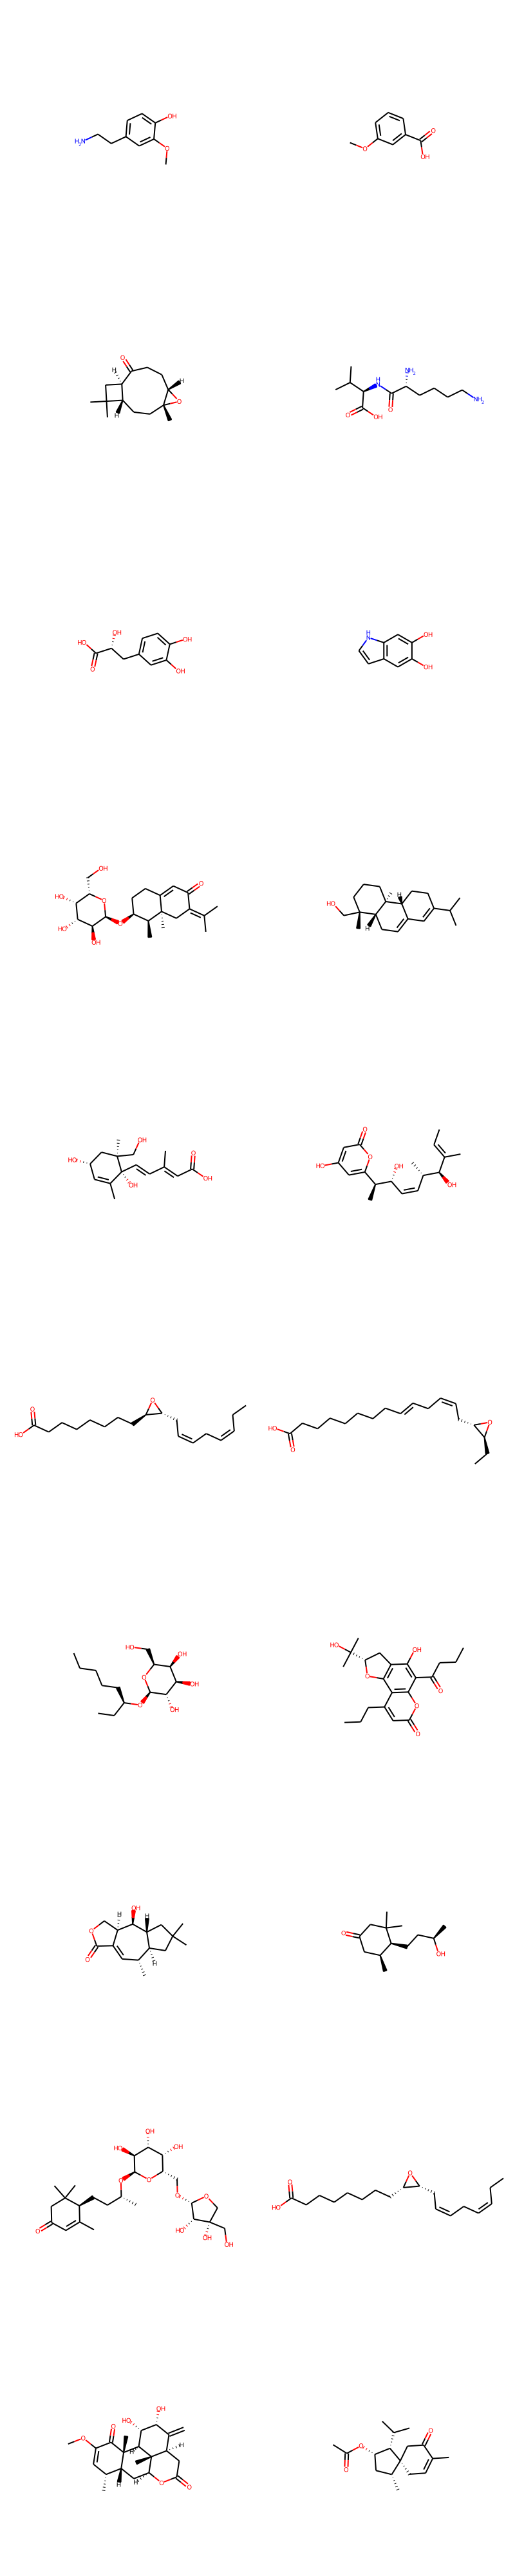

In [34]:
rdkit.Chem.Draw.MolsToGridImage(best_predicted_mols, molsPerRow=2, maxMols=100, subImgSize=(400, 400))